In [1000]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [1001]:
import wntr
import pandas as pd
import numpy as np
import copy
import networkx as nx
import torch
from wntr.graphics import plot_network
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix

In [1002]:
inp_file = 'tree_net.inp'

### Network Topology Without Leak Junctions

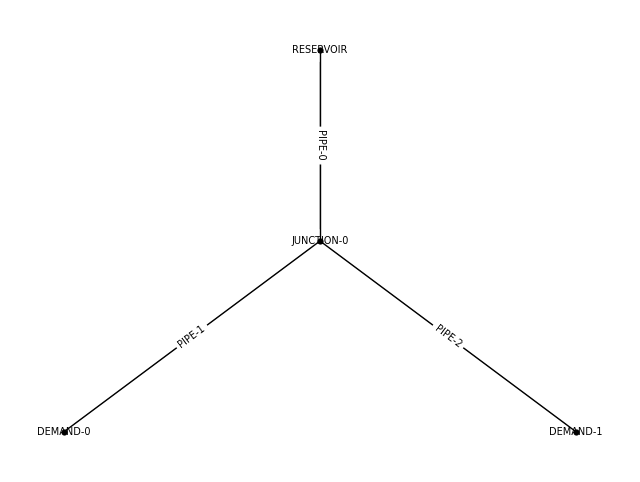

In [1003]:
# Plot just the structure of the network
base_wn = wntr.network.WaterNetworkModel(inp_file)

display(Markdown("### Network Topology Without Leak Junctions"))

fig, ax = plt.subplots(figsize=(8, 6))
plot_network(base_wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [1004]:
num_pipes = len(base_wn.pipe_name_list)
pipe_names = [f'PIPE-{i}' for i in range(num_pipes)] 
leak_junctions = [f'LEAK-{i}' for i in range(num_pipes)] 

In [1005]:
for i, pn in enumerate(pipe_names):
    base_wn = wntr.morph.split_pipe(base_wn, pn, pn + '_B', f'LEAK-{i}')

### Network Topology With Leak Junctions

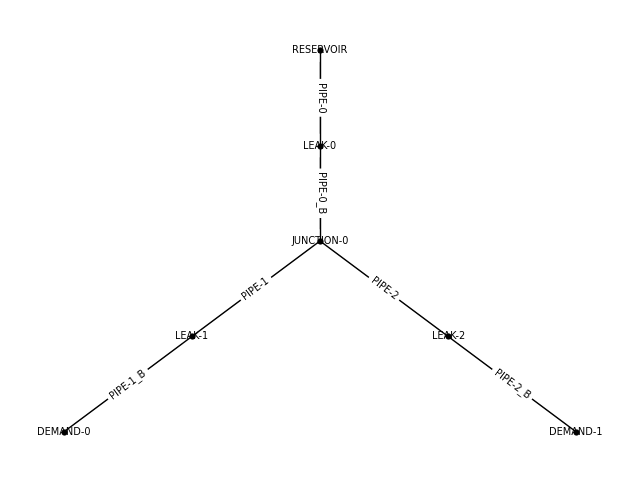

In [1006]:
# Plot just the structure of the network

display(Markdown("### Network Topology With Leak Junctions"))

fig, ax = plt.subplots(figsize=(8, 6))
plot_network(base_wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [1007]:
n_samples = 10
Cd = 0.75
max_ratio = 1
diamater = 1

leak_ratio = np.linspace(0, max_ratio, n_samples)
leak_areas = 3.14159 * (diamater*leak_ratio / 2) ** 2



leak_node_id = 'LEAK-0'  # Where to inject the leak
#base_wn = wntr.network.WaterNetworkModel(inp_file)

supply_nodes = base_wn.reservoir_name_list
flow_data = []

for leak_node_id in leak_junctions:

    for area in leak_areas:
        wn = copy.deepcopy(base_wn)

        # Add leak at specified node
        junction = wn.get_node(leak_node_id)
        junction.add_leak(wn, area=area, discharge_coeff=Cd, start_time=0)

        # Run simulation
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()

        # Get flow at t=0
        flow = results.link['flowrate'].iloc[0]
    

        # Add to results
        flow_row = {'Leak Node ID' : leak_node_id, 'Leak Area': area}
        flow_row.update(flow)
        flow_data.append(flow_row)

flow_df = pd.DataFrame(flow_data)
base_flows = flow_df[flow_df.columns[2:]].iloc[0].to_numpy()
display(flow_df)


,Leak Node ID,Leak Area,PIPE-0,PIPE-1,PIPE-2,PIPE-0_B,PIPE-1_B,PIPE-2_B
0,LEAK-0,0.000000,0.100000,0.050000,0.050000,0.100000,0.05,0.05
1,LEAK-0,0.009696,0.327468,0.050000,0.050000,0.100000,0.05,0.05
2,LEAK-0,0.038785,1.001405,0.050000,0.050000,0.100000,0.05,0.05
3,LEAK-0,0.087266,2.065384,0.050000,0.050000,0.100000,0.05,0.05
4,LEAK-0,0.155140,3.361371,0.050000,0.050000,0.100000,0.05,0.05
5,LEAK-0,0.242407,4.646039,0.050000,0.050000,0.100000,0.05,0.05
6,LEAK-0,0.349066,5.711876,0.050000,0.050000,0.100000,0.05,0.05
7,LEAK-0,0.475117,6.485716,0.050000,0.050000,0.100000,0.05,0.05
8,LEAK-0,0.620561,7.004484,0.050000,0.050000,0.100000,0.05,0.05
9,LEAK-0,0.785397,7.340515,0.050000,0.050000,0.100000,0.05,0.05


In [1008]:
# Build re-ordering of graph edges
G = wn.to_graph()
edgelist = list(G.edges())
order = []
for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)
    idx = edgelist.index((pipe.start_node_name, pipe.end_node_name))
    order.append(idx)
    
edgelist = np.array(edgelist)[order]

In [1009]:
reservoirs = list(wn.reservoir_name_list)
# Get all node names
all_nodes = list(G.nodes())

# Filter out reservoirs
non_reservoir_nodes = [n for n in all_nodes if n not in reservoirs]
idx = [i for i, n in enumerate(all_nodes) if n not in reservoirs]
A  = nx.incidence_matrix(G, oriented=True)
A0 = torch.tensor(A[idx,:].toarray(), dtype=torch.float32)[:,order]


In [1010]:
# Create mapping matrix M (local leak node idx -> global leak node idx)

# Map node names to row indices in your reduced incidence matrix A0
node_to_index = {n: i for i, n in enumerate(non_reservoir_nodes)}

M = torch.zeros((len(non_reservoir_nodes), len(leak_junctions)))

# Set 1 where the leak area should be applied
for j, leak_junction in enumerate(leak_junctions):
    i = node_to_index[leak_junction]
    M[i, j] = 1.0

In [1011]:
# Create mapping matrix B (local supply node idx -> global supply pipe idx)

supply_nodes = wn.reservoir_name_list 
supply_nodes = list(supply_nodes) 

# Create edge-to-start-node mapping
edge_start_nodes = [edge[0] for edge in edgelist]

# Create B matrix (|E| x |supply_nodes|), sparse
B = dok_matrix((len(edgelist), len(supply_nodes)), dtype=int)

for i, (start_node) in enumerate(edge_start_nodes):
    if start_node in supply_nodes:
        j = supply_nodes.index(start_node)
        B[i, j] = 1

# Convert to CSR format for efficient arithmetic
B = torch.tensor(B.toarray(), dtype=torch.float32)

In [1012]:
junctions = wn.junction_name_list

# Get base demands at each junction
D_values = []
for name in junctions:
    junction = wn.get_node(name)
    demand = junction.base_demand
    D_values.append(demand)

D = torch.tensor(D_values, dtype=torch.float32)

In [1013]:
supply_nodes = wn.reservoir_name_list  # Or include tanks if needed

# Get heads at each supply node
S_values = []
for name in supply_nodes:
    reservoir = wn.get_node(name)
    head = reservoir.base_head  # This is constant in steady state
    S_values.append(head)

S = torch.tensor(S_values, dtype=torch.float32)

In [1014]:
pipe_names = wn.pipe_name_list 

# Get length of each pipe (in meters)
L = torch.tensor([wn.get_link(name).length for name in pipe_names], dtype=torch.float32)

# Get diameter of each pipe (in meters)
d = torch.tensor([wn.get_link(name).diameter for name in pipe_names], dtype=torch.float32)

# Get Hazen-Williams roughness coefficients (unitless)
C = torch.tensor([wn.get_link(name).roughness for name in pipe_names], dtype=torch.float32)

In [1015]:
inv = torch.linalg.inv(A0.T)

In [ ]:
model_params = {
    'A0': A0,
    'inv' : inv,
    'M' : M,
    'B' : B,
    'a_max' : leak_areas.max(),
    'S' : S,
    'D' : D,
    'd': d,
    'L': L,
    'Cd' : 0.75, 
    'C' : C,
    'rho' : 1000.0,
    'n_samples' : 10,
}

net_params = {
        'layer_sizes' : [M.shape[1],42,42,42,A0.shape[0]], 
        'activation' : 'relu',
        'base' : base_flows
}


In [1017]:
model = Model(model_params, net_params)
model.train(iterations=50000, print_interval=1000)

step       loss       e1          e2
1000       6.02e-02   New Best!
2000       1.03e-02   New Best!
3000       4.11e-03   New Best!
4000       5.07e-03   
5000       2.72e-03   New Best!
6000       1.76e-03   New Best!
7000       3.40e-03   
8000       2.29e-03   
9000       1.35e-03   New Best!
10000      5.89e-04   New Best!
11000      8.33e-03   
12000      1.94e-02   
13000      2.12e-02   
14000      5.42e-04   New Best!
15000      3.52e-04   New Best!
16000      9.18e-04   
17000      5.89e-03   
18000      6.46e-04   
19000      5.64e-04   
20000      1.66e-03   
21000      1.31e-03   
22000      1.31e-03   
23000      1.87e-03   
24000      6.09e-04   
25000      2.44e-03   
26000      9.51e-04   
27000      3.27e-04   New Best!
28000      2.67e-03   
29000      2.03e-03   
30000      3.12e-04   New Best!
31000      3.28e-03   
32000      1.55e-03   
33000      3.83e-04   
34000      2.63e-03   
35000      1.36e-03   
36000      1.81e-03   
37000      6.31e-04   
38000      1.

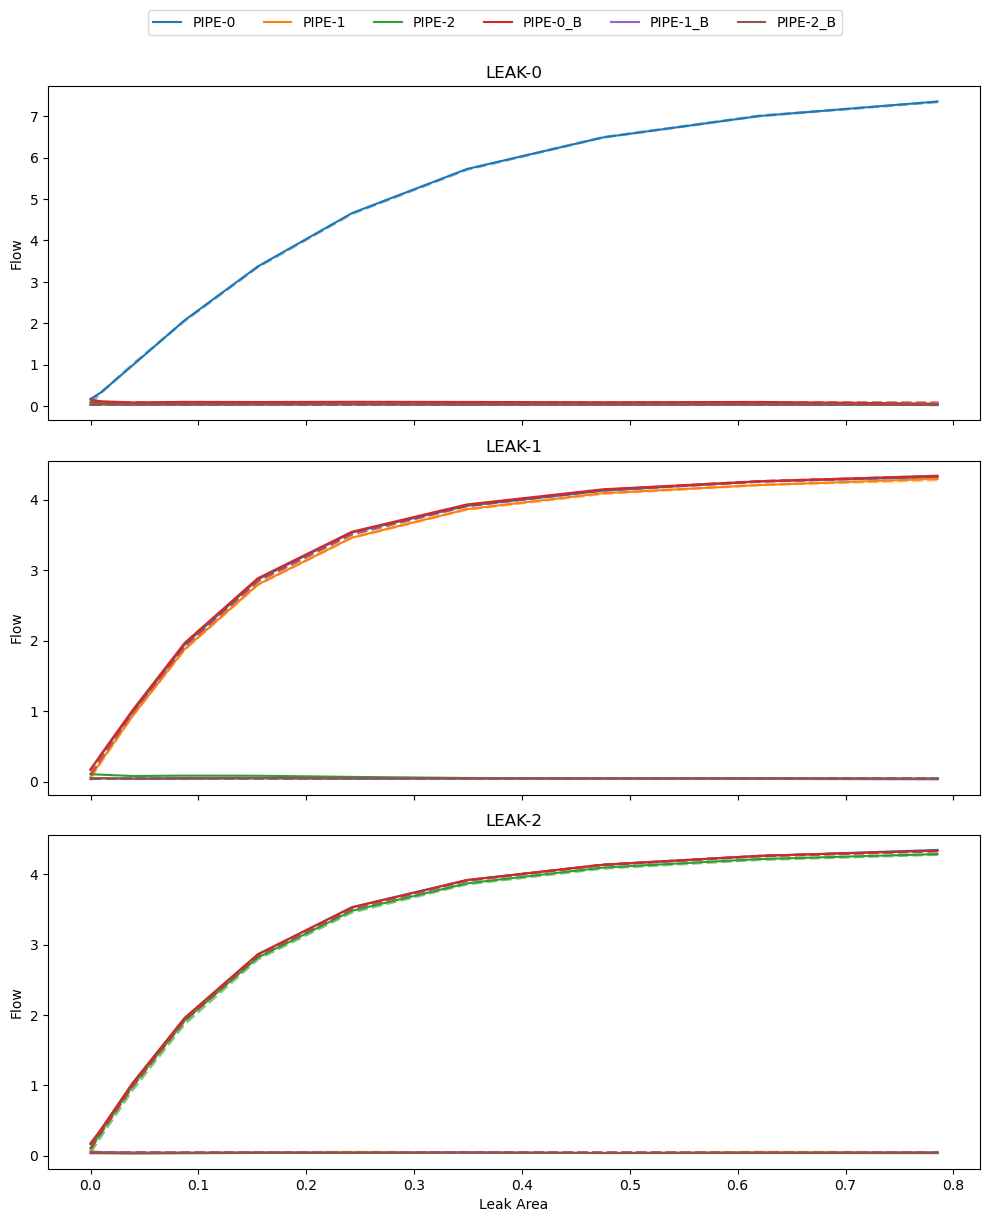

In [1018]:

true_df = flow_df.drop(columns=['Leak Area'])

fig, axs = plt.subplots(num_pipes, 1, figsize=(10, 4 * num_pipes), sharex=True)
axs = np.atleast_1d(axs)

# Only store legend handles/labels once
legend_handles = []

for i in range(num_pipes):
    a = torch.zeros((n_samples, num_pipes))
    a[:,i] = torch.tensor(leak_areas, dtype=torch.float32)
    q = model.net(a).detach().numpy()
    
    true_df = flow_df[flow_df['Leak Node ID'] == f'LEAK-{i}'].drop(columns=['Leak Node ID'])
    true = true_df.drop(columns=['Leak Area']).to_numpy()
    pipe_names = list(flow_df.columns[2:])
    
    q_df = pd.DataFrame(q, columns=pipe_names)
    error_df = pd.DataFrame((q - true) / true, columns=pipe_names)
    q_df.insert(0, 'Leak Area', leak_areas)
    error_df.insert(0, 'Leak Area', leak_areas)
    
    
    ax = axs[i]

    # Plot predicted values and collect handles/labels only once
    for j, pipe in enumerate(pipe_names):
        line, = ax.plot(q_df['Leak Area'], q_df[pipe], label=pipe)
        if i == 0:  # Collect handles only from the first subplot
            legend_handles.append(line)

        # Plot ground truth as dashed, thick, semi-transparent line
        ax.plot(true_df['Leak Area'], true_df[pipe], color=line.get_color(), linestyle='--', alpha=0.6, linewidth=2)

    ax.set_title(f"LEAK-{i}")
    ax.set_ylabel("Flow")

axs[-1].set_xlabel("Leak Area")

# Shared legend above all subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=len(pipe_names), bbox_to_anchor=(0.5, 1.02))
fig.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend
plt.show()


In [1019]:
display(q_df)
display(true_df)

,Leak Area,PIPE-0,PIPE-1,PIPE-2,PIPE-0_B,PIPE-1_B,PIPE-2_B
0,0.000000,0.180169,0.067298,0.105867,0.166231,0.050955,0.036617
1,0.009696,0.373103,0.054629,0.336340,0.375214,0.052717,0.036776
2,0.038785,1.025101,0.046800,0.990545,1.030016,0.046921,0.032708
3,0.087266,1.956353,0.045503,1.919979,1.958408,0.044871,0.036703
4,0.155140,2.858535,0.052691,2.816527,2.864241,0.048184,0.041030
5,0.242407,3.532364,0.056096,3.480480,3.528899,0.045536,0.040180
6,0.349066,3.918907,0.051734,3.871025,3.915311,0.044982,0.047343
7,0.475117,4.132964,0.041737,4.094643,4.135223,0.040376,0.039362
8,0.620561,4.259698,0.056064,4.215946,4.262108,0.042146,0.039869
9,0.785397,4.345627,0.053648,4.286147,4.333779,0.048260,0.038293


,Leak Area,PIPE-0,PIPE-1,PIPE-2,PIPE-0_B,PIPE-1_B,PIPE-2_B
20,0.000000,0.100000,0.05,0.050000,0.100000,0.05,0.05
21,0.009696,0.326942,0.05,0.276942,0.326942,0.05,0.05
22,0.038785,0.983581,0.05,0.933581,0.983581,0.05,0.05
23,0.087266,1.923154,0.05,1.873154,1.923154,0.05,0.05
24,0.155140,2.843181,0.05,2.793181,2.843181,0.05,0.05
25,0.242407,3.509637,0.05,3.459637,3.509637,0.05,0.05
26,0.349066,3.909731,0.05,3.859731,3.909731,0.05,0.05
27,0.475117,4.132951,0.05,4.082951,4.132951,0.05,0.05
28,0.620561,4.257244,0.05,4.207244,4.257244,0.05,0.05
29,0.785397,4.328519,0.05,4.278519,4.328519,0.05,0.05
